
# The structure of this jupyter notebook:
1. Load model
2. Solve model
3. Simulate model
4. Plot model results 

    i. Average over age

    ii. All simulation over age

    iii. Solutions for each grid point over age (2D)
    
    iV. solutions for specific grid points in 3D

5. Welfare analysis
     
    i. Replacement rate

    ii. Consumption replacement rate

    iii. Consumption equivalence

# Load model 

In [87]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct
from bernoulli_distribution import Bernoulli
from help_functions_non_njit import *
from graph_format import *
# load local model file and initialize model class
from model import ModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

# Solve model

In [89]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=False)

CPU times: total: 6min 1s
Wall time: 1min 15s



# Simulate model

In [90]:
%time model.simulate()

CPU times: total: 33.4 s
Wall time: 6.35 s


# Plot model results

In [91]:
time = np.arange(par.T)
data_dict = {
    "Human Capital (k)": {"data": model.sim.k[:], "unit": "%"},
    "Wages (w)": {"data": model.sim.w[:], "unit": "DKK"},
    "Hours Worked": {"data": np.where(model.sim.ex == 1, model.sim.h, np.nan), "unit": "hours"},
    "Assets (a)": {"data": model.sim.a[:], "unit": "DKK"},
    "Consumption (c)": {"data": model.sim.c[:], "unit": "DKK"},
    "Illiquid Savings (s)": {"data": model.sim.s[:], "unit": "DKK"},
    "Participation (ex)": {"data": model.sim.ex[:], "unit": "%"},
    "Tax Rate": {"data": np.where(model.sim.ex == 1, model.sim.tax_rate, np.nan), "unit": "%"},
    "After-tax Wages": {"data": (1 - model.sim.tax_rate[:,:]) * model.sim.w[:,:], "unit": "DKK"},
    "Early Retirement Rate": {"data":model.sim.e[:,:] == 2.0, "unit": "%"},
}


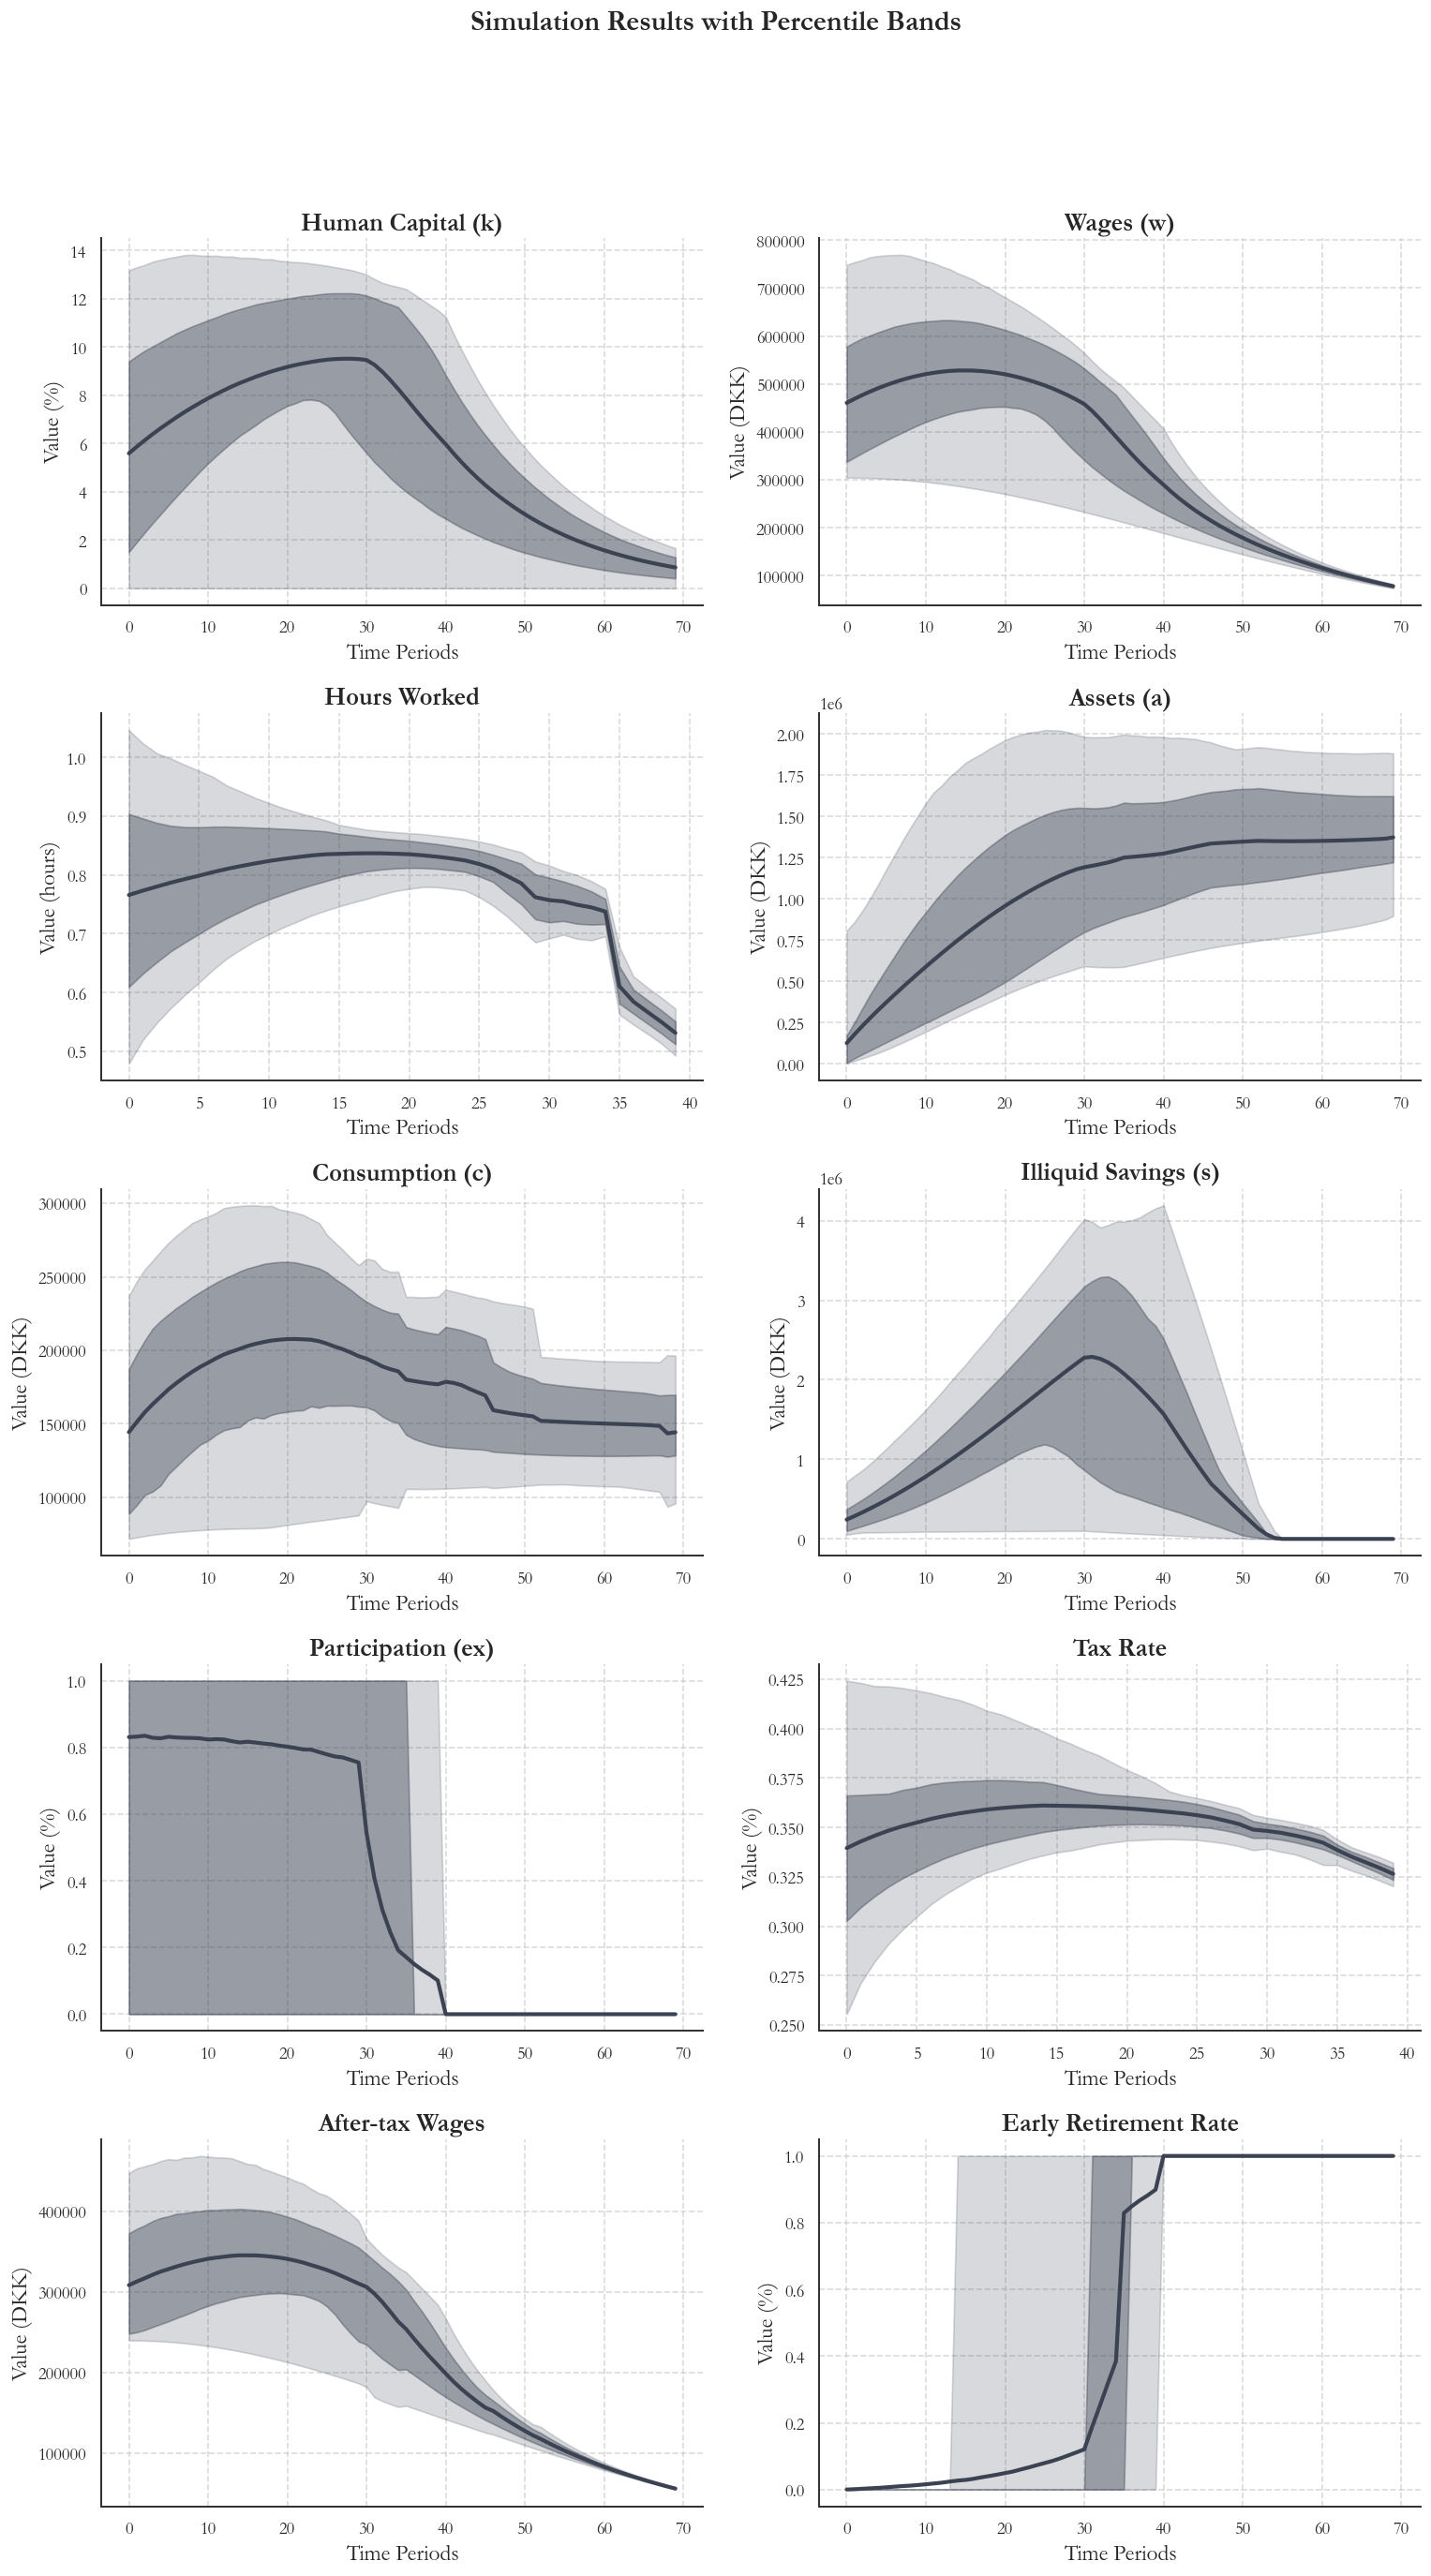

In [112]:
plot_simulation_grid_percentiles(
    data_dict=data_dict,
    time=np.arange(70),
    title="Simulation Results with Percentile Bands",
    ncols=2,
    save_title="baseline_simulation_percentiles_grid.png"
)

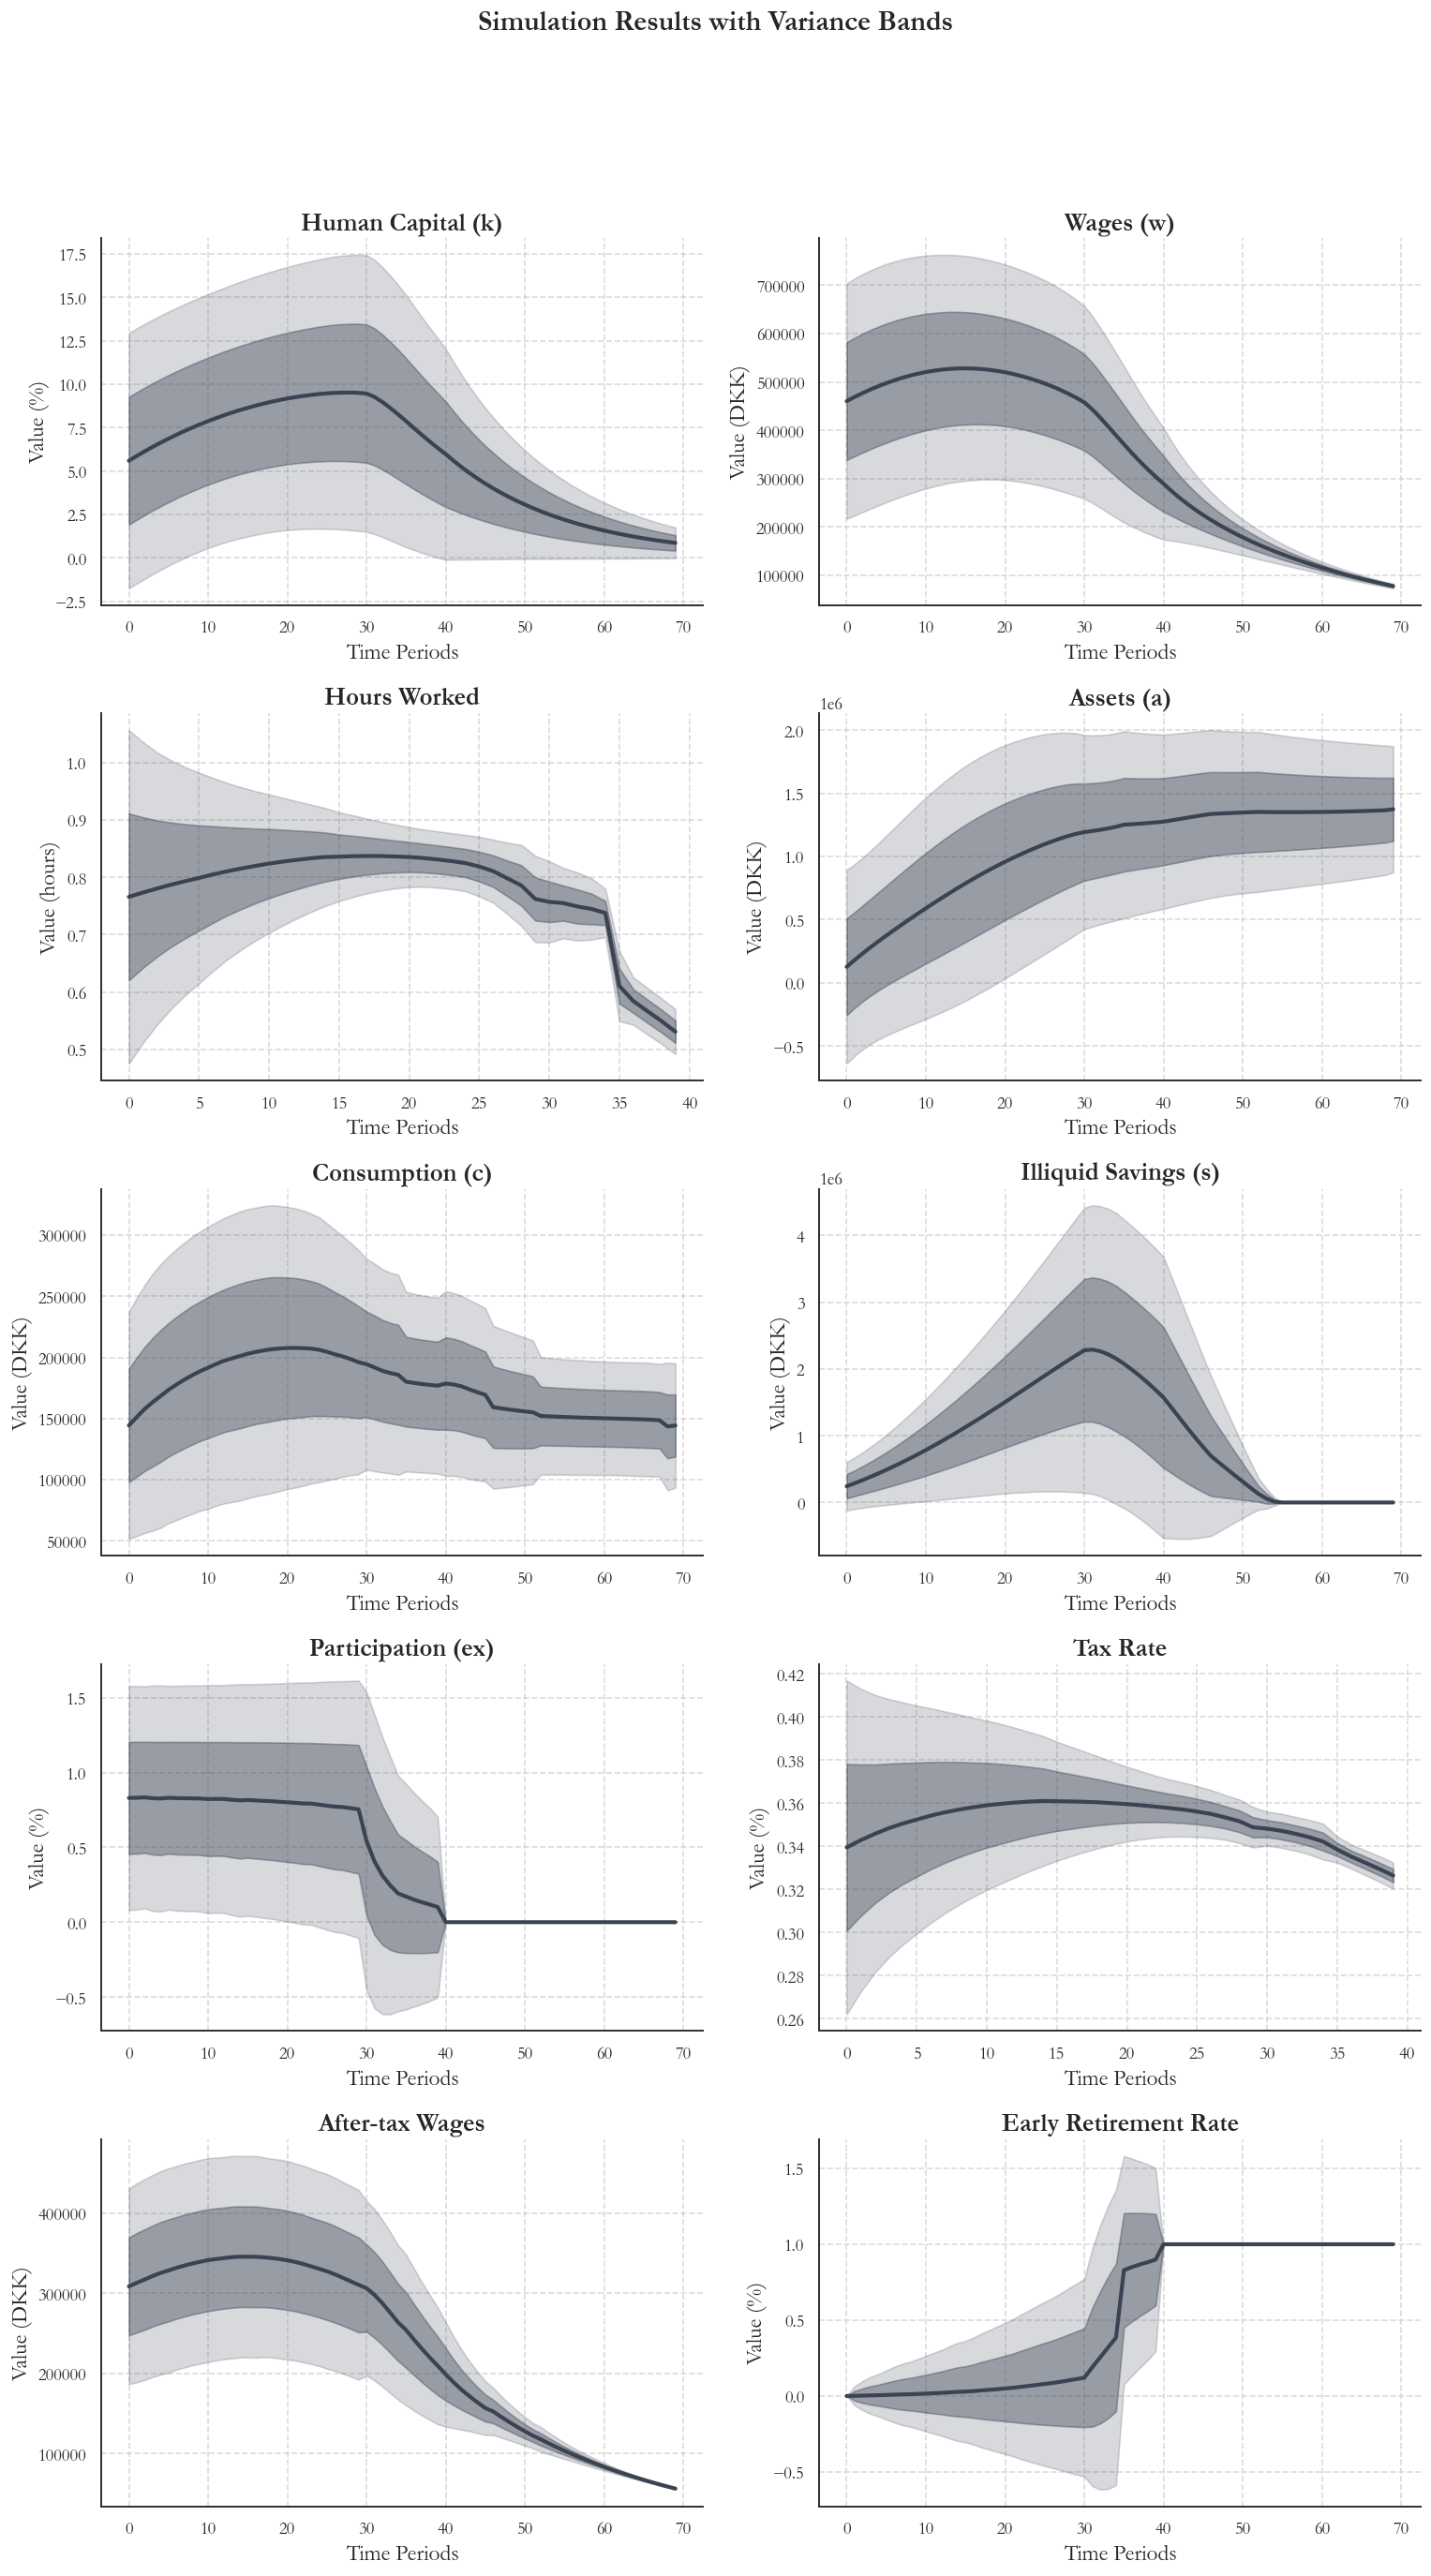

In [113]:
plot_simulation_grid_variance(
    data_dict=data_dict,
    time=np.arange(70),
    title="Simulation Results with Variance Bands",
    save_title="baseline_simulation_variance_grid.png"
)


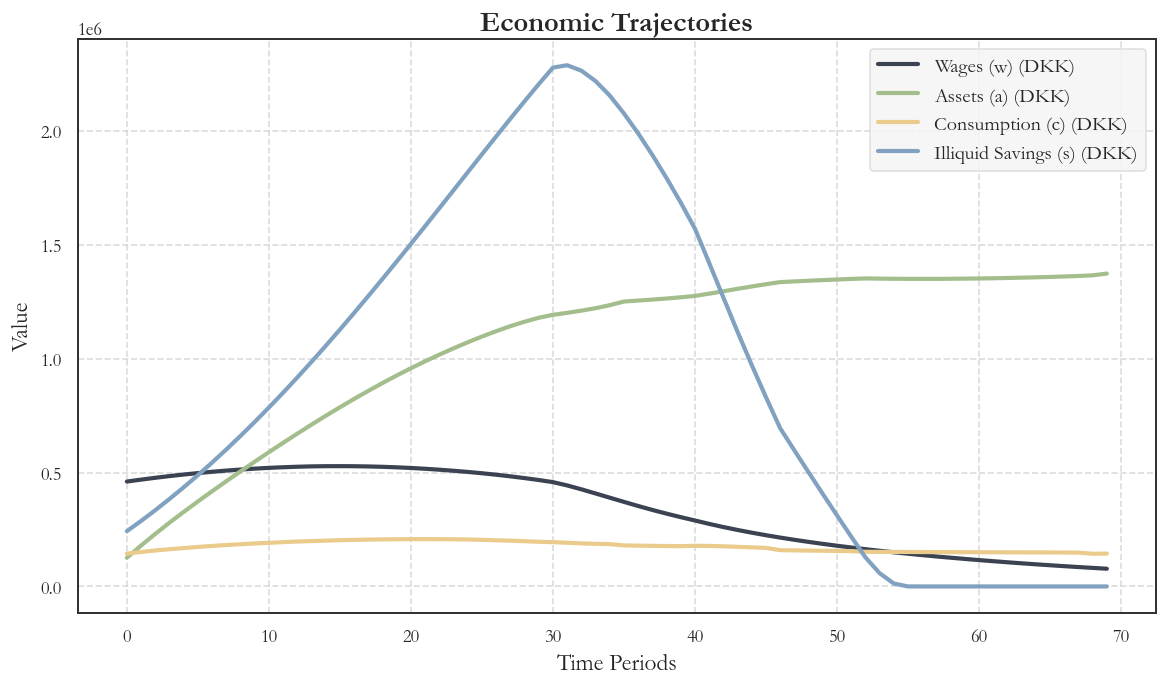

In [114]:
data_dict_basic = {
    "Wages (w)": {"data": np.mean(model.sim.w[:], axis=0), "unit": "DKK"},
    "Assets (a)": {"data": np.mean(model.sim.a[:], axis=0), "unit": "DKK"},
    "Consumption (c)": {"data": np.mean(model.sim.c[:], axis=0), "unit": "DKK"},
    "Illiquid Savings (s)": {"data": np.mean(model.sim.s[:], axis=0), "unit": "DKK"},
}

plot_simulation_one_graph(data_dict_basic, time, title="Economic Trajectories",
    save_title="baseline_model_simpel.png")


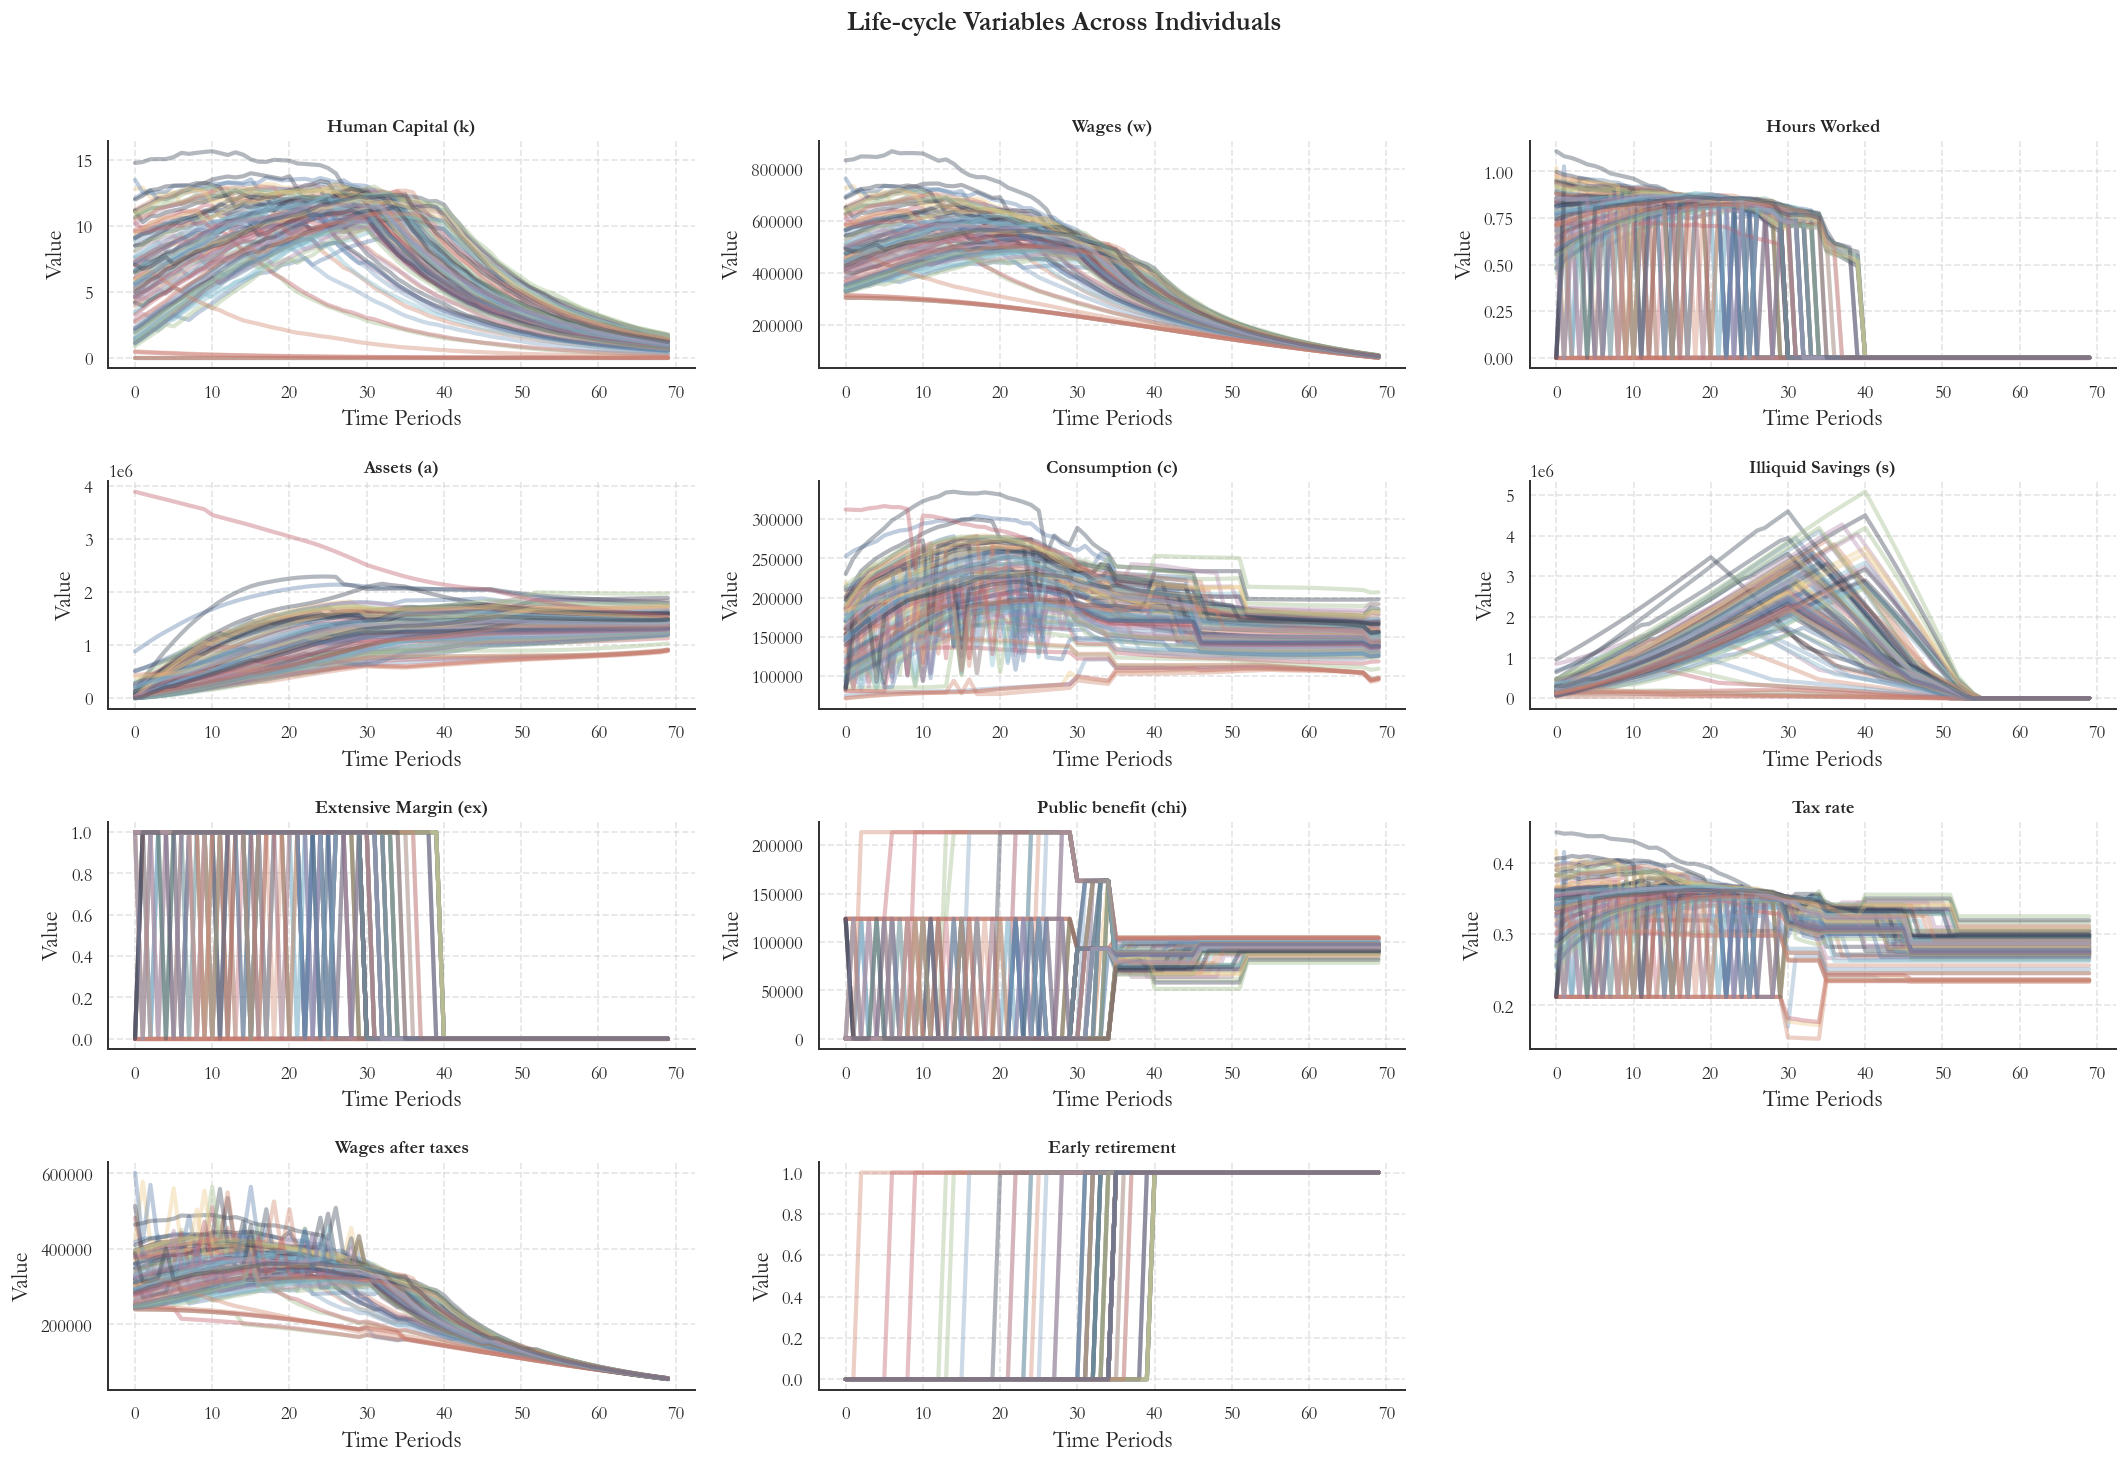

In [115]:
variables_dict = {
    "Human Capital (k)": lambda sim, i: sim.k[i, :par.T],
    "Wages (w)": lambda sim, i: sim.w[i, :par.T],
    "Hours Worked": lambda sim, i: sim.h[i, :par.T],
    "Assets (a)": lambda sim, i: sim.a[i, :par.T],
    "Consumption (c)": lambda sim, i: sim.c[i, :par.T],
    "Illiquid Savings (s)": lambda sim, i: sim.s[i, :par.T],
    "Extensive Margin (ex)": lambda sim, i: sim.ex[i, :par.T],
    "Public benefit (chi)": lambda sim, i: sim.chi_payment[i, :par.T],
    "Tax rate": lambda sim, i: sim.tax_rate[i, :par.T],
    "Wages after taxes": lambda sim, i: (1 - sim.tax_rate[i, :par.T]) * sim.w[i, :par.T],
    "Early retirement": lambda sim, i: sim.e[i, :par.T] == 2.0,
}

plot_variable_panels_over_individuals(sim=model.sim, par=par, variables_dict=variables_dict,
                                      title="Life-cycle Variables Across Individuals",
                                      ncols=3, max_i=100,
    save_title="baseline_simulatin_individual.png")


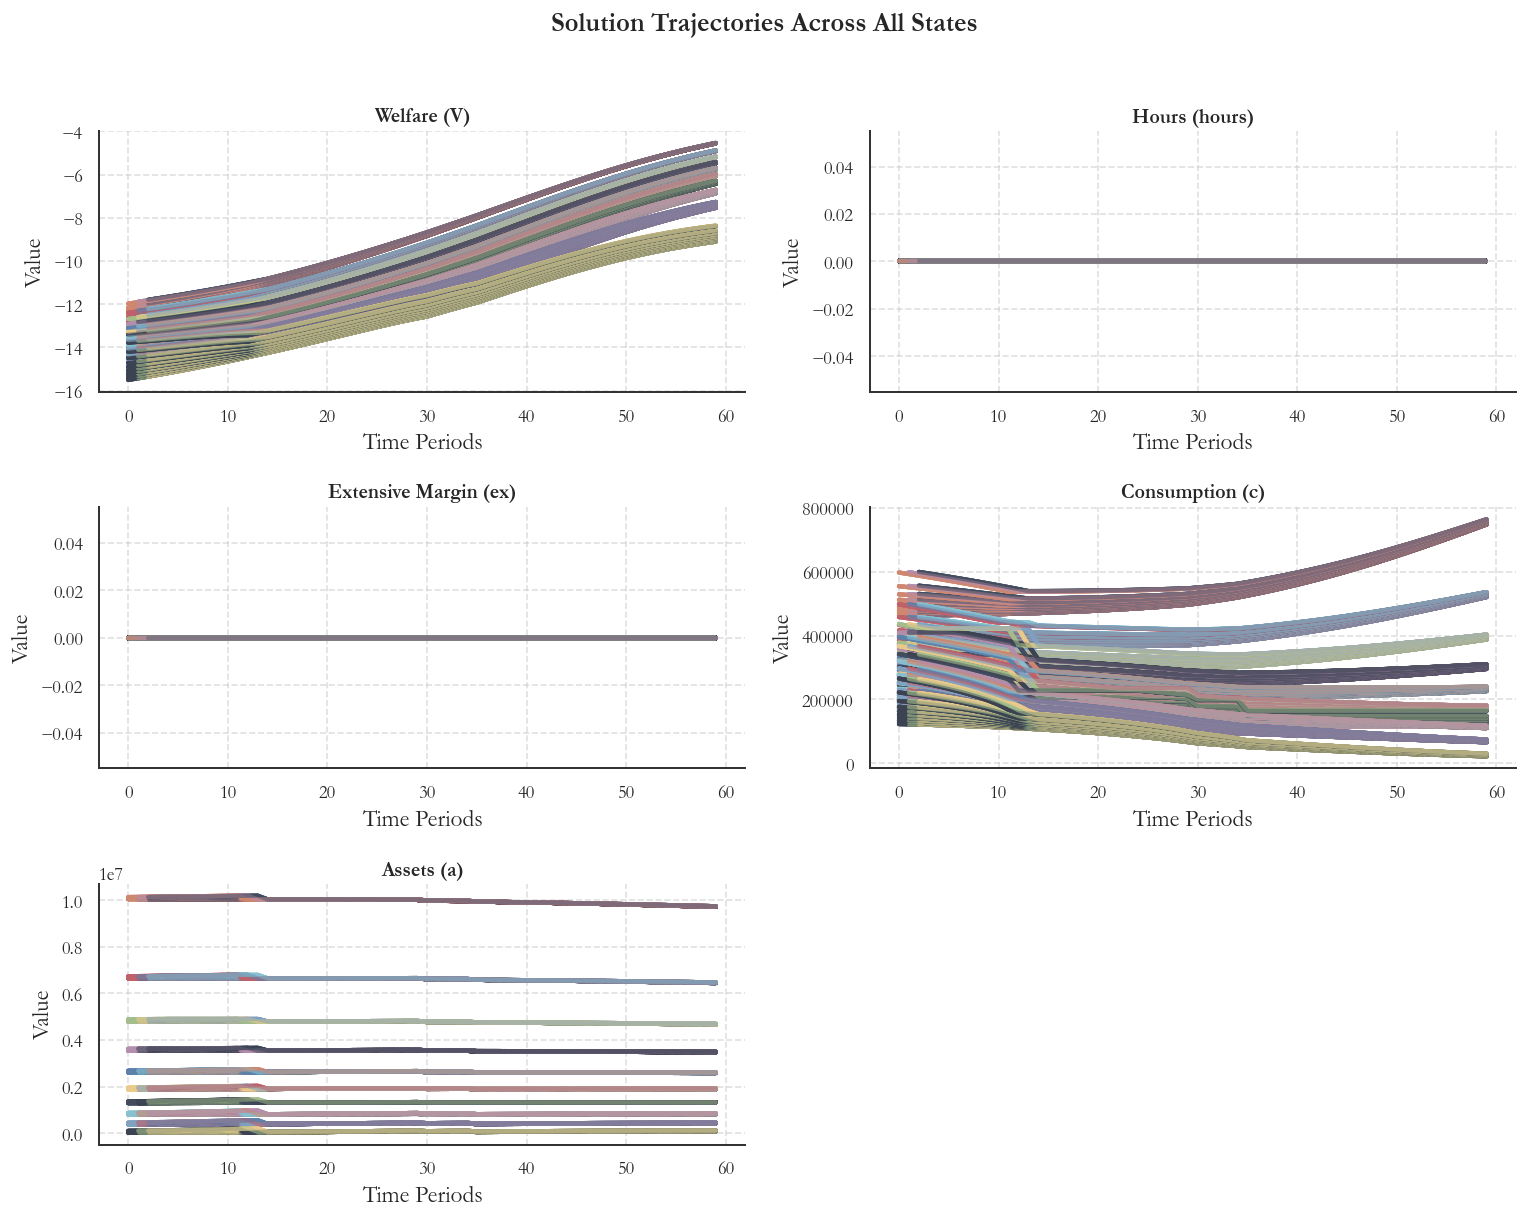

In [116]:
plot_all_solution_trajectories(model, par, t_end=60,
    save_title="baseline_solutions.png")


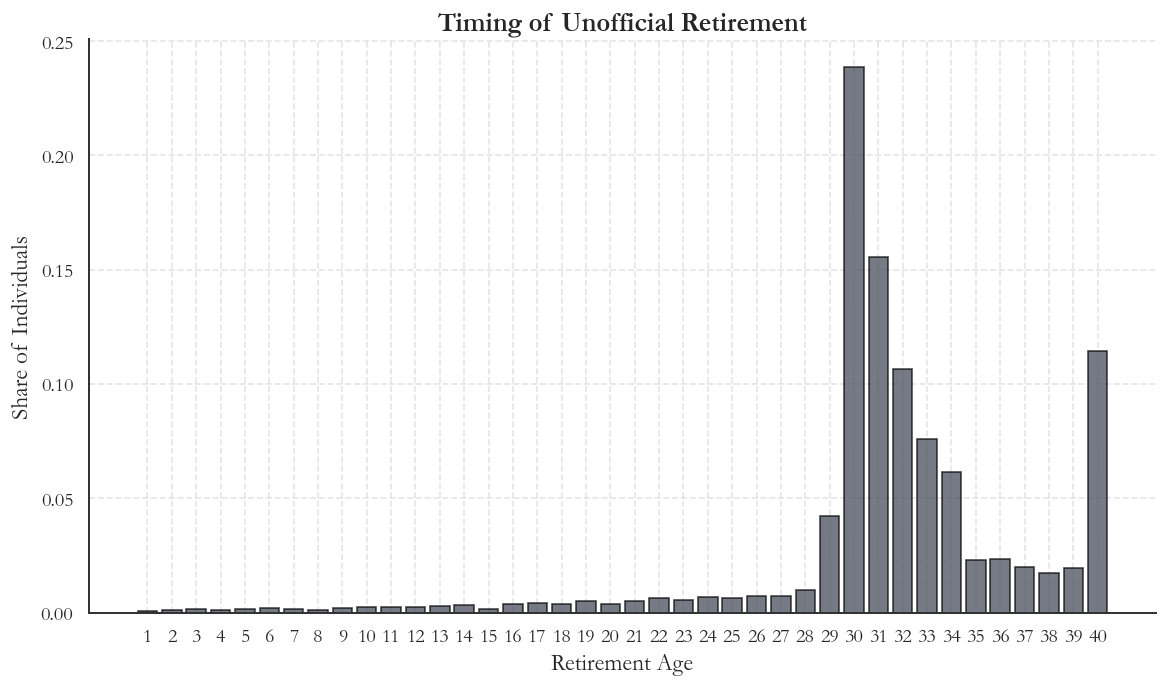

In [117]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(sim.ex.shape[0], np.nan)  # initialize

for i in range(sim.ex.shape[0]):
    working = np.where(sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1] + 1 # last time they worked (take last index)
plot_event_bar_series(
    values1=last_working,
    xlabel="Retirement Age",
    title="Timing of Unofficial Retirement",
    label1="Last Work",
    save_title="baseline_unofficial.png"
)


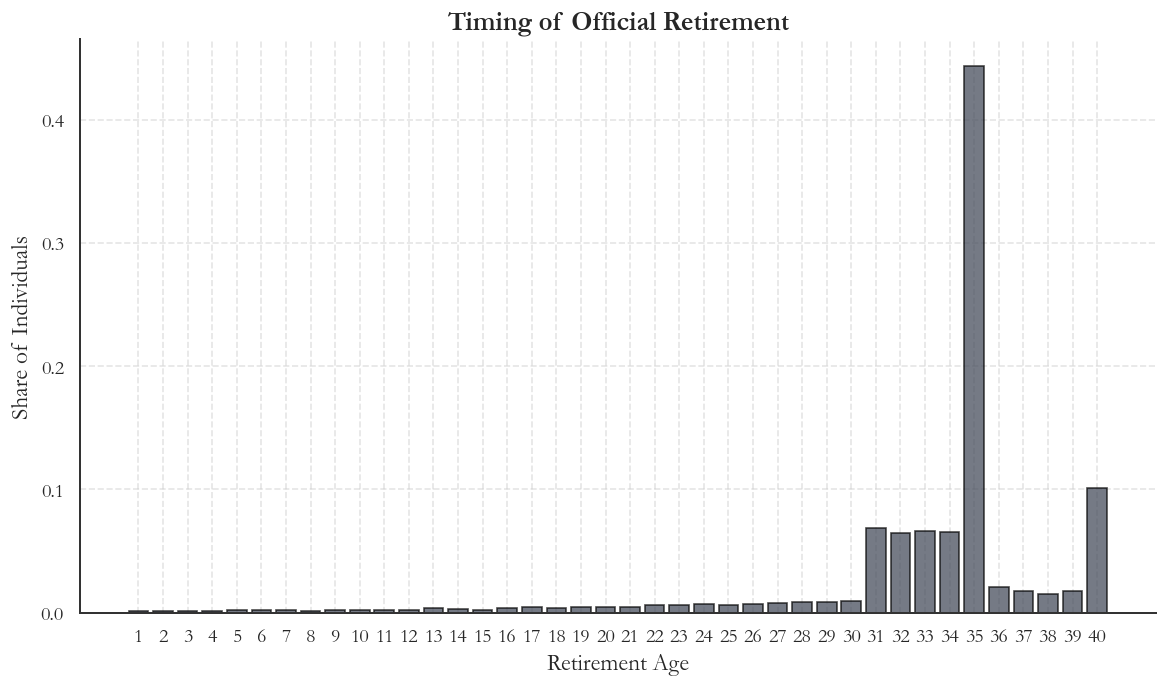

In [118]:
# 1. Find first time e == 2 for each individual
first_retirement = np.full(sim.e.shape[0], np.nan)  # initialize

for i in range(sim.e.shape[0]):
    retired = np.where(sim.e[i, :] == 2)[0]  # find where e=2
    if retired.size > 0:
        first_retirement[i] = retired[0]  # first time they retire
plot_event_bar_series(
    values1=first_retirement,
    xlabel="Retirement Age",
    title="Timing of Official Retirement",
    save_title="baseline_official.png"
)


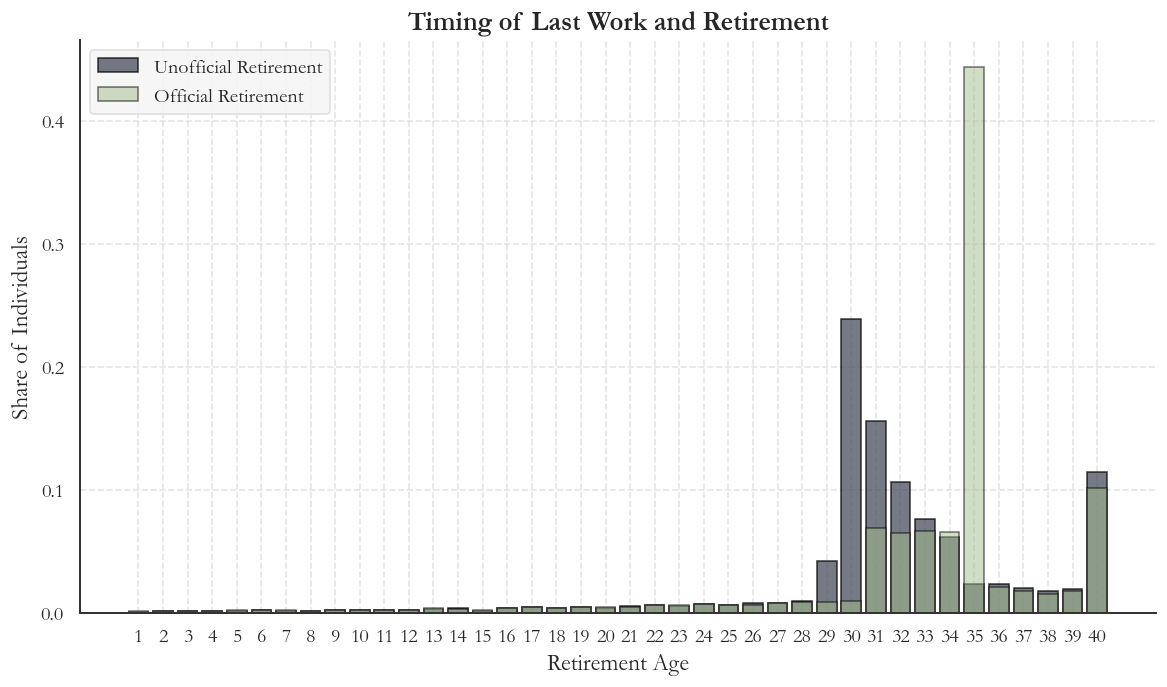

In [119]:
plot_event_bar_series(
    values1=last_working,
    values2=first_retirement,
    xlabel="Retirement Age",
    title="Timing of Last Work and Retirement",
    label1="Unofficial Retirement",
    label2="Official Retirement",
    save_title="baseline_unofficial_official.png"
)


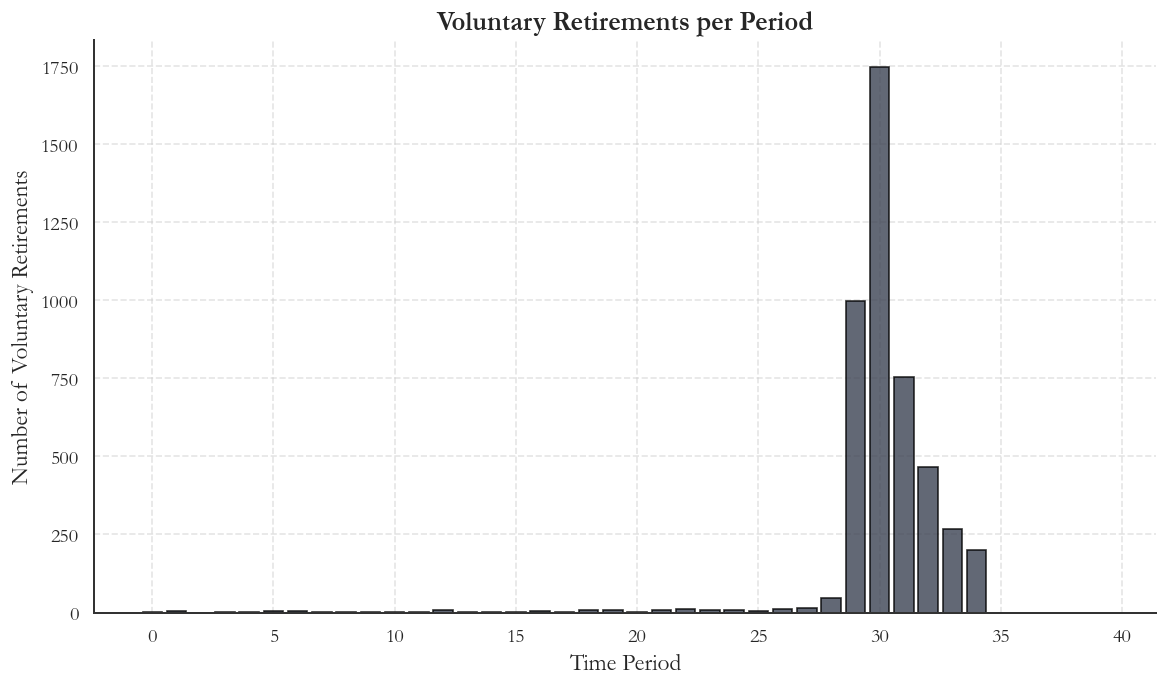

In [120]:
ret_counts = np.sum(model.sim.ret_flag[:, :], axis=0)
plot_bar_series(ret_counts, xlabel="Time Period", ylabel="Number of Voluntary Retirements", title="Voluntary Retirements per Period",
    save_title="baseline_voluntary.png")


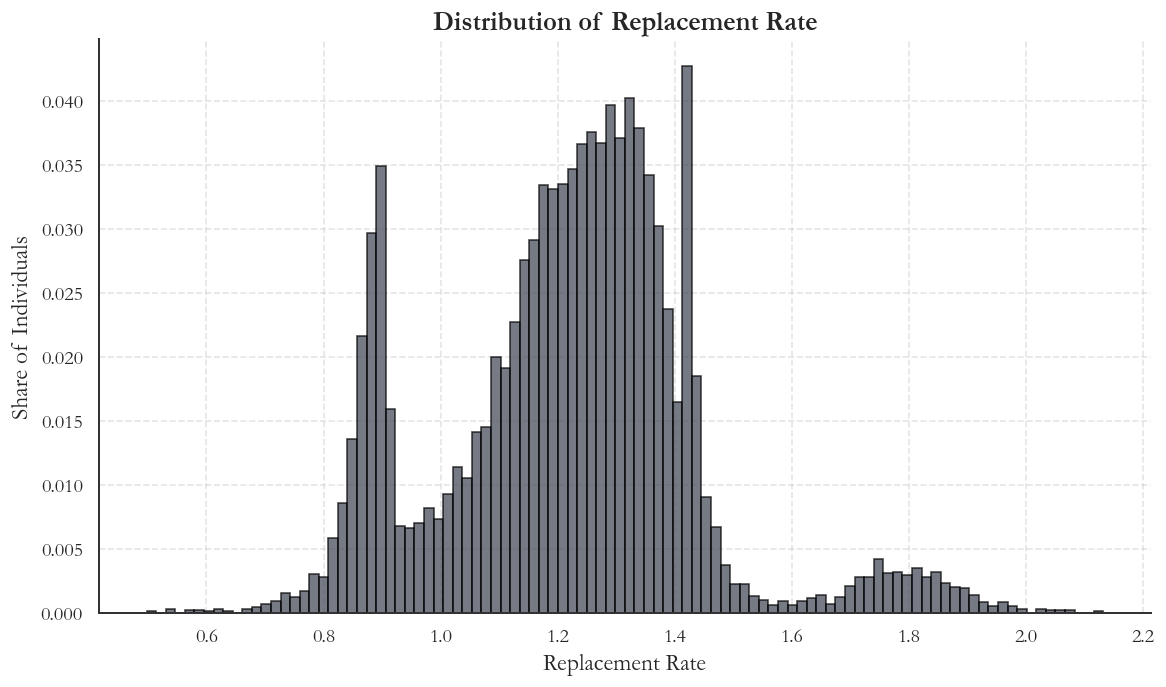

In [121]:
plot_event_histogram(replacement_rate_fct(model), xlabel="Replacement Rate", title="Distribution of Replacement Rate", bins=100,
    save_title="baseline_replacement.png")


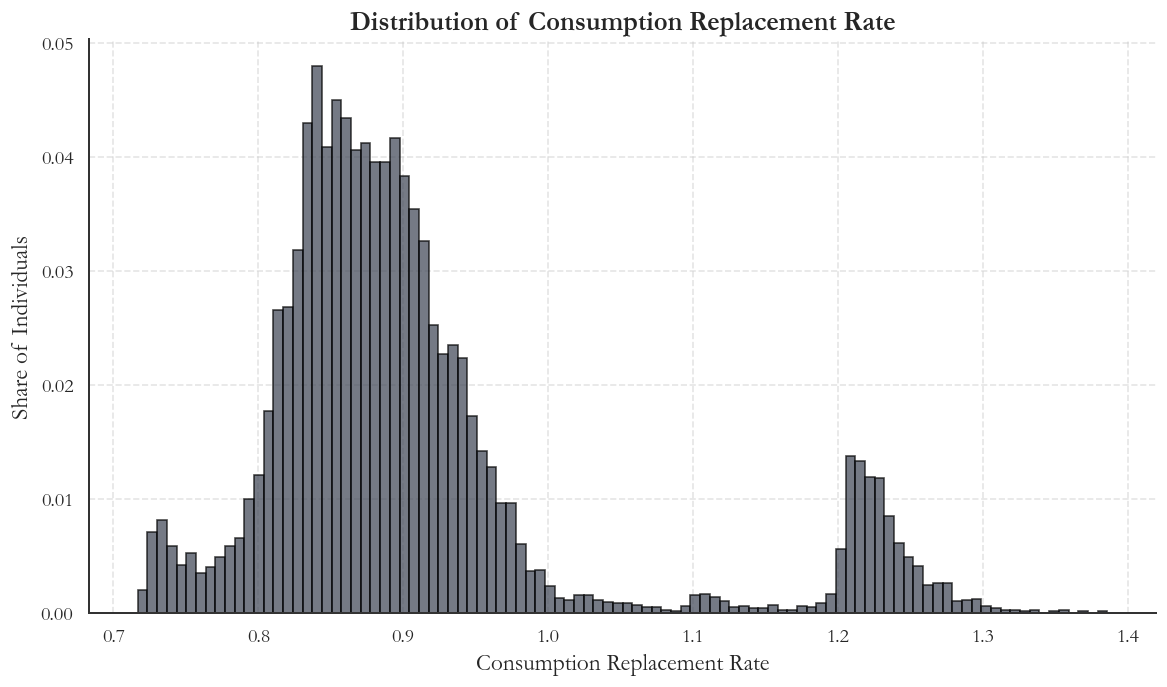

In [122]:
plot_event_histogram(consumption_replacement_rate_fct(model), xlabel="Consumption Replacement Rate", title="Distribution of Consumption Replacement Rate", bins=100,
    save_title="baseline_con_replacement.png")


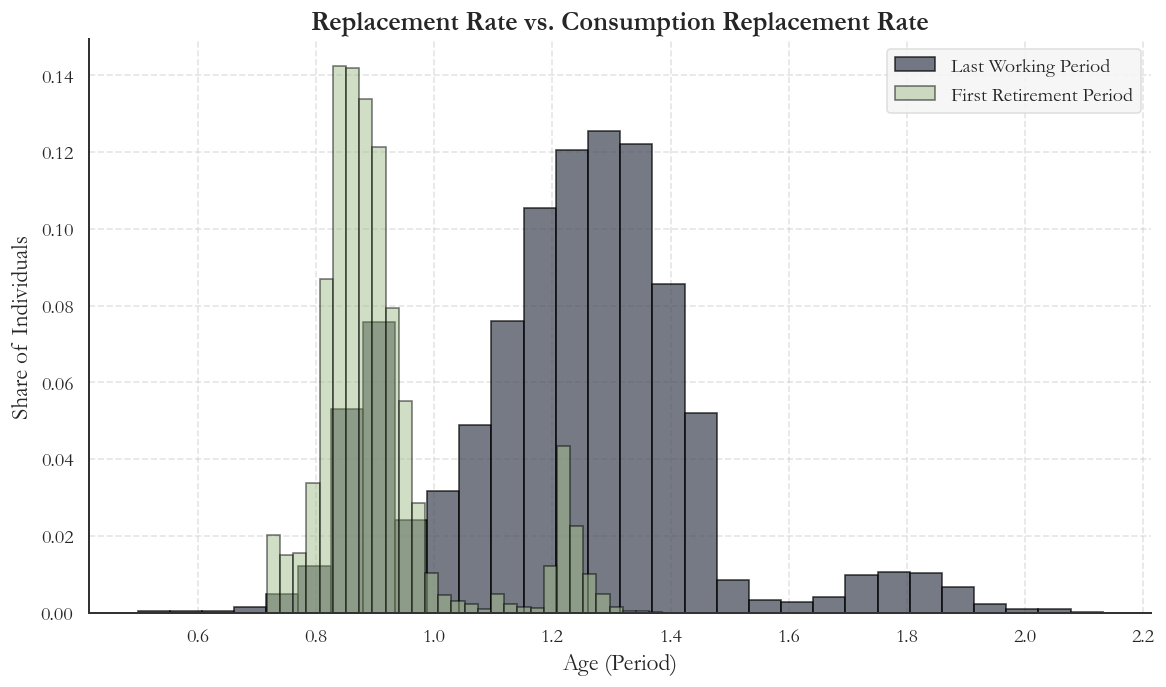

In [123]:
plot_event_histogram(
    values1=replacement_rate_fct(model),
    values2=consumption_replacement_rate_fct(model),
    xlabel="Age (Period)",
    title="Replacement Rate vs. Consumption Replacement Rate",
    label1="Last Working Period",
    label2="First Retirement Period",
    bins=30,
    save_title="baseline_con_and_replacement.png"
)


In [124]:
np.mean(np.sum(model.sim.ret_flag[:,:],axis=1))

np.float64(0.4618)

In [125]:
# To help find nan values
if np.isnan(sim.c).any():
    count = 0 
    list_of_nan = []
    for i in range(sim.c.shape[0]):
        if np.isnan(sim.c[i,35]):
            print(i)
            list_of_nan.append(i)
            count +=1
    # Create a 3x2 grid of subplots
    fig, axes = plt.subplots(6, 2, figsize=(12, 8))

    # Titles for the plots
    titles = [
        "Human Capital (k)", "Wages (w)", "Hours (hours)", 
        "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"
    ]

    t_end = par.T 
    # Generate example data (replace with actual values)
    time = np.arange(t_end)
    for i in list_of_nan[:3]:
        data_dict = {
            "Human Capital (k)": model.sim.k[i,:t_end],
            "Wages (w)": model.sim.w[i,:t_end],
            "Hours (hours)": model.sim.h[i,:t_end],
            "Assets (a)": model.sim.a[i,:t_end],
            "Consumption (c)": model.sim.c[i,:t_end],
            "Illiquid Savings (s)": model.sim.s[i,:t_end],
            "Extensive Margin (ex)": model.sim.ex[i,:t_end],
            "Public benefit (chi)": model.sim.chi_payment[i,:t_end],
            "Tax rate (tax_rate)": model.sim.tax_rate[i,:t_end],
            "Wages after taxes": (1-model.sim.tax_rate[i,:t_end])*model.sim.w[i,:t_end],
            "Early retirement": np.sum([model.sim.e[i,:t_end] == 2.0 for i in range(model.sim.e.shape[0])], axis=0) / model.sim.e.shape[0],
        }
        # Plot each variable in its respective subplot
        for ax, (label, data) in zip(axes.flatten(), data_dict.items()):
            ax.plot(time, data)
            ax.set_title(label)
            ax.set_xlabel("Time Periods")
            ax.set_ylabel("Value")
            ax.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    print('Antal der fejler ',count)